# Extended Dynamic Mode Decomposition (EDMD)

## Introduction

Dynamic Mode Decomposition (DMD) is a powerful data-driven technique for analyzing complex dynamical systems. **Extended DMD (EDMD)** enhances the classical DMD approach by incorporating a broader library of observables or features, enabling better capture of nonlinear dynamics and improved predictive accuracy.

### What is EDMD?

EDMD extends traditional DMD by:
- **Feature enrichment**: Using nonlinear functions of the state variables (e.g., polynomials, Fourier modes, radial basis functions)
- **Koopman operator theory**: Identifying linear modes in a higher-dimensional space where nonlinear dynamics appear linear
- **Enhanced expressivity**: Better representation of complex, nonlinear systems with fewer modes

### This Notebook

We will explore:
- EDMD algorithm for Stuart-Landau equation
- Application to benchmark dynamical systems
- Mode visualization and interpretation
- Predictive modeling

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir('/home/pg221/PhD_projects3/DMD_for_chapter/')

We take Stuart-Landau equations as example
```markdown

Stuart-Landau Oscillator

The Stuart-Landau equation is a canonical model for studying nonlinear oscillations and bifurcations. It describes the dynamics of a complex amplitude A in the form:

```
$$
\begin{align}
   \frac{dA}{dt}&= \delta A-\mu A|A|^2,
\end{align}
$$

where $\delta$ is a control parameter that separates a stable region $(\delta < 0)$ for the fixed point $A = 0$ from an unstable one $ \delta>0$, and $ \mu $ is a complex constant. For the following numerical setup we consider, $ \delta = 0.1 $ and $ \omega = 3.0 $

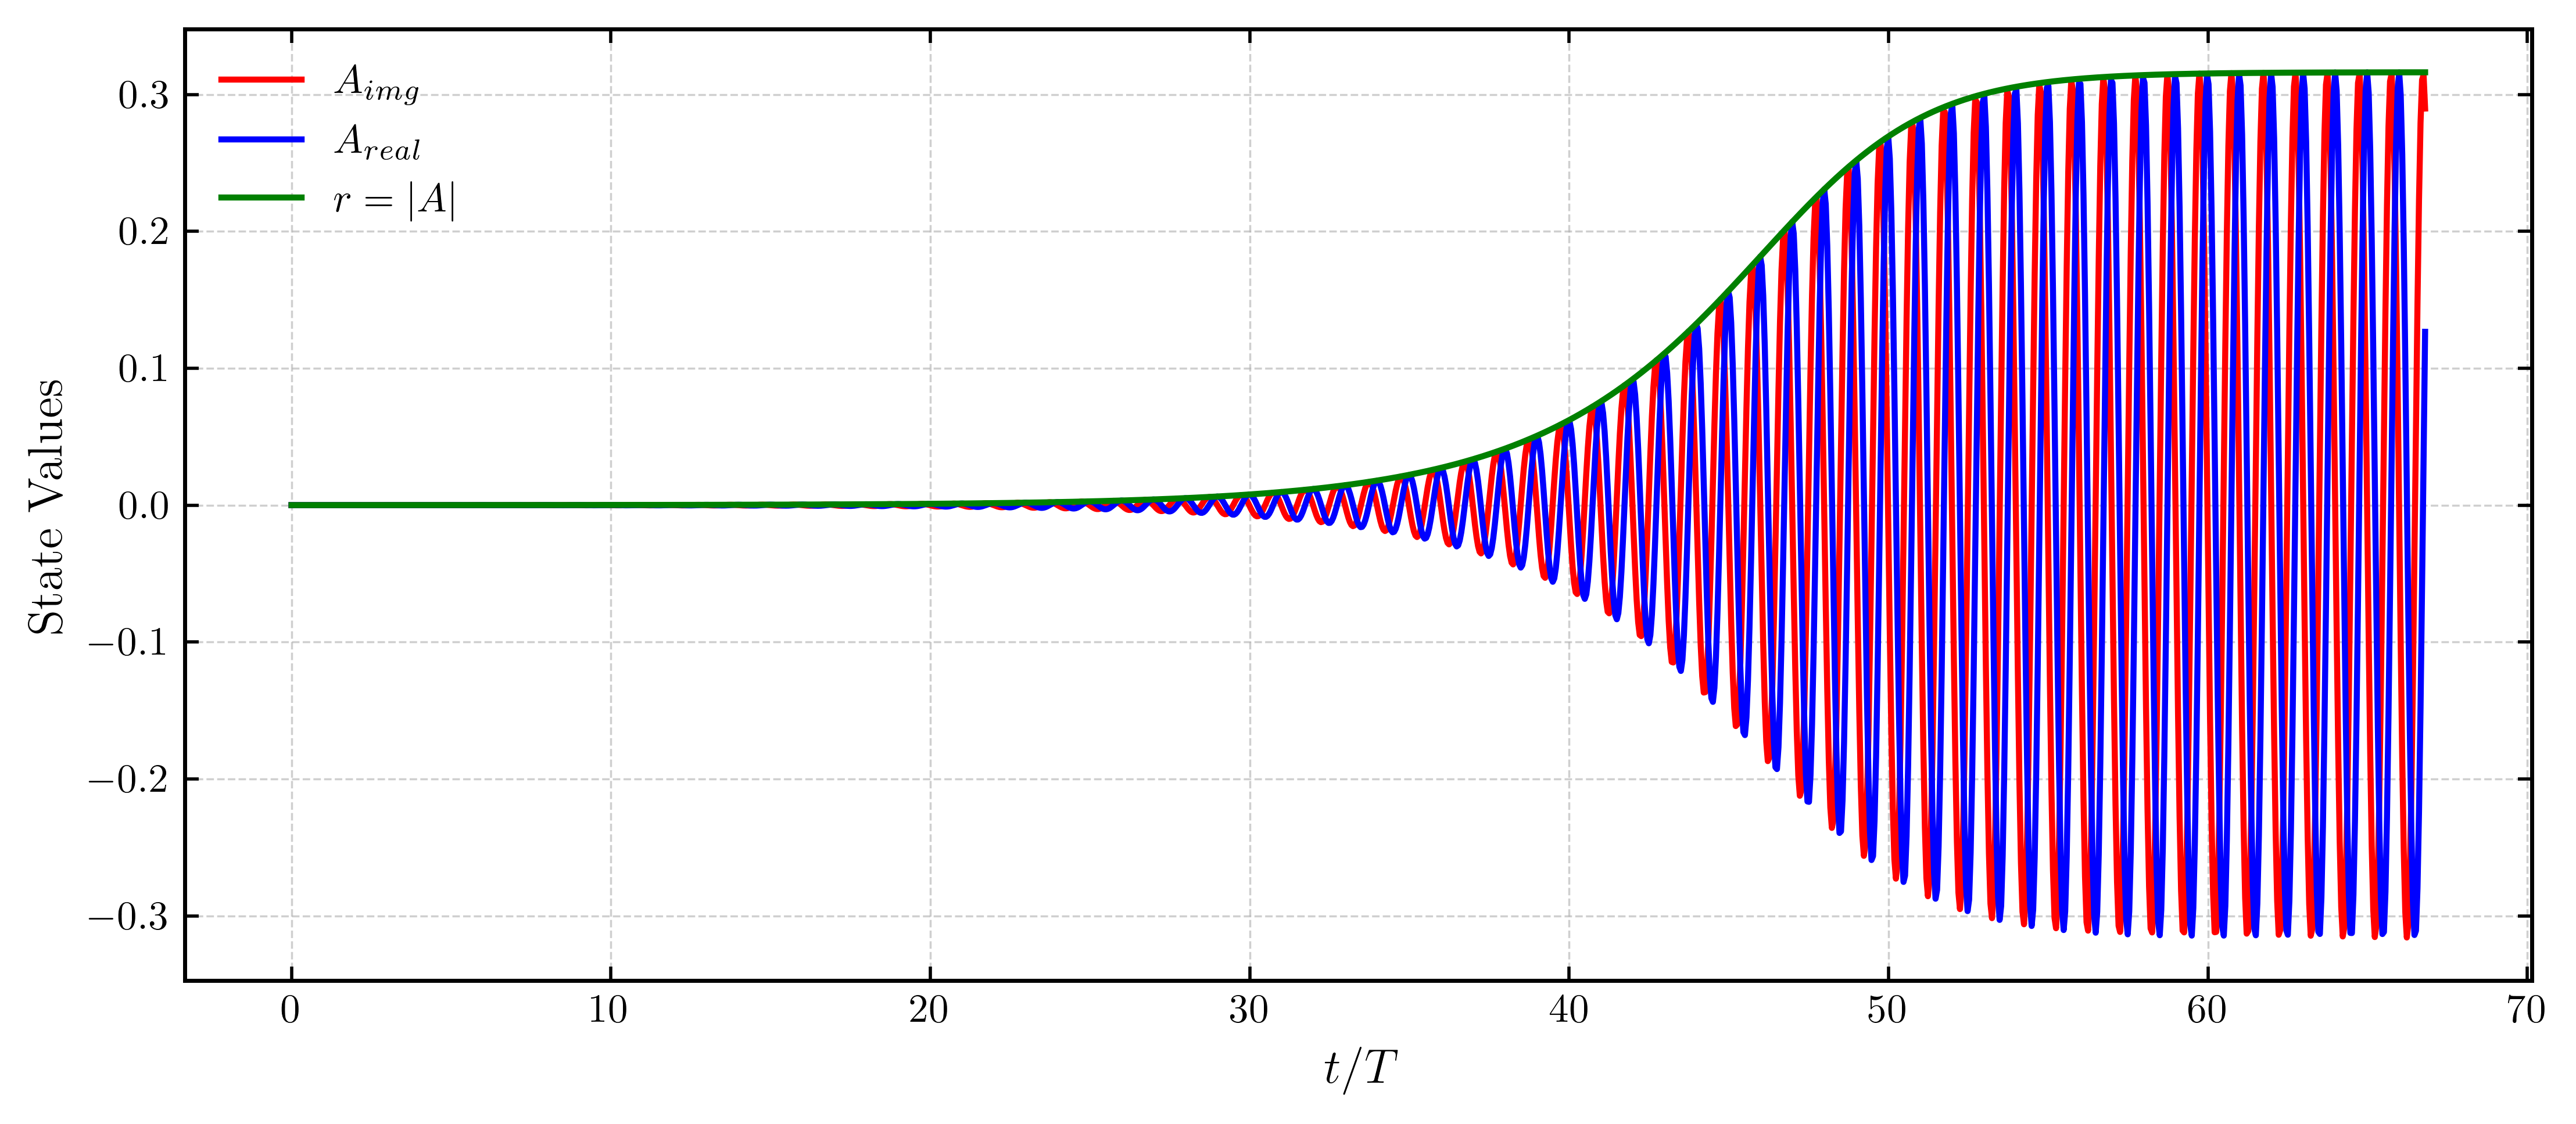

In [2]:
from osc_envs.osc_gym import OscillatorEnv

dt = 0.1
omega = 3.0
env = OscillatorEnv(params={"amplitude": 0.3, "initial_transition_steps": 2})

states = np.array([]).reshape(0, env.observation_space.shape[0])
time_steps = 2000

env.reset()
for j in range(time_steps):
    state , reward, _,_,_ = env.step(action = np.zeros(env.action_space.shape))
    states = np.vstack([states, state])



from matplotlib import rcParams
# ====== Plot ======
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 11,          # main text font = 10 pt
    "axes.labelsize": 12,     # ≈ 1.1× main text
    "xtick.labelsize": 10,     # ≈ 0.9×
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "mathtext.fontset": "cm",
    "axes.linewidth": 1.0,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
    "figure.figsize": (9, 4),
    "savefig.dpi": 500,
    "savefig.bbox": "tight",
})

freq = omega/(2* np.pi)
T = 1/freq
t = np.arange(time_steps) * dt/T

fig, ax = plt.subplots(dpi = 500)
obs = [r"$A_{img}$", r"$A_{real}$", r"$r = |A|$"]
colors = ["r","blue","green"]
for i in range(states.shape[1]):
    ax.plot(t[:1400], states[:1400,i][:], label=obs[i], color=colors[i])

ax.set_xlabel(r'$t/T$')
ax.set_ylabel('State Values')
ax.legend(frameon=False)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()


We consider a dictionary of observables 
$$
\begin{equation}
    \mathbf{f} = \left[A_{\text{img}},\; A_{\text{real}},\; R,\; R^2,\; R^3,\; R^4\right]^T
\end{equation}
$$

The **extended DMD algorithm** proceeds as follows.
Assume we have $n_t$ snapshots $\mathbf{f}_{t=0,\cdots,n_t-1}$ at times $t\Delta t$.
The objective is to find a finite-dimensional matrix $\mathbf{K}$ such that:
$$
\mathbf{f}_t = \mathbf{K}\mathbf{f}_{t-1}, \quad t = 1, \cdots, n_t - 1.
$$

We can write:
$$
\underbrace{
\begin{bmatrix}
f_{0,1} & f_{0,2} & \cdots & f_{0,n_t} \\
f_{1,1} & f_{1,2} & \cdots & f_{1,n_t} \\
\vdots  & \vdots  & \ddots & \vdots     \\
f_{p-1,1} & f_{p-1,2} & \cdots & f_{p-1,n_t}
\end{bmatrix}
}_{\mathbf{F}^{1,n_t}}
=
\mathbf{K}
\underbrace{
\begin{bmatrix}
f_{0,0} & f_{0,1} & \cdots & f_{0,n_t-1} \\
f_{1,0} & f_{1,1} & \cdots & f_{1,n_t-1} \\
\vdots  & \vdots  & \ddots & \vdots     \\
f_{p-1,0} & f_{p-1,1} & \cdots & f_{p-1,n_t-1}
\end{bmatrix}
}_{\mathbf{F}^{0,n_t-1}}.
$$


We construct the above data matrices close to the limit-cycle in the code snippet below and plot the time trajectory of the snapshots.

(800, 7)


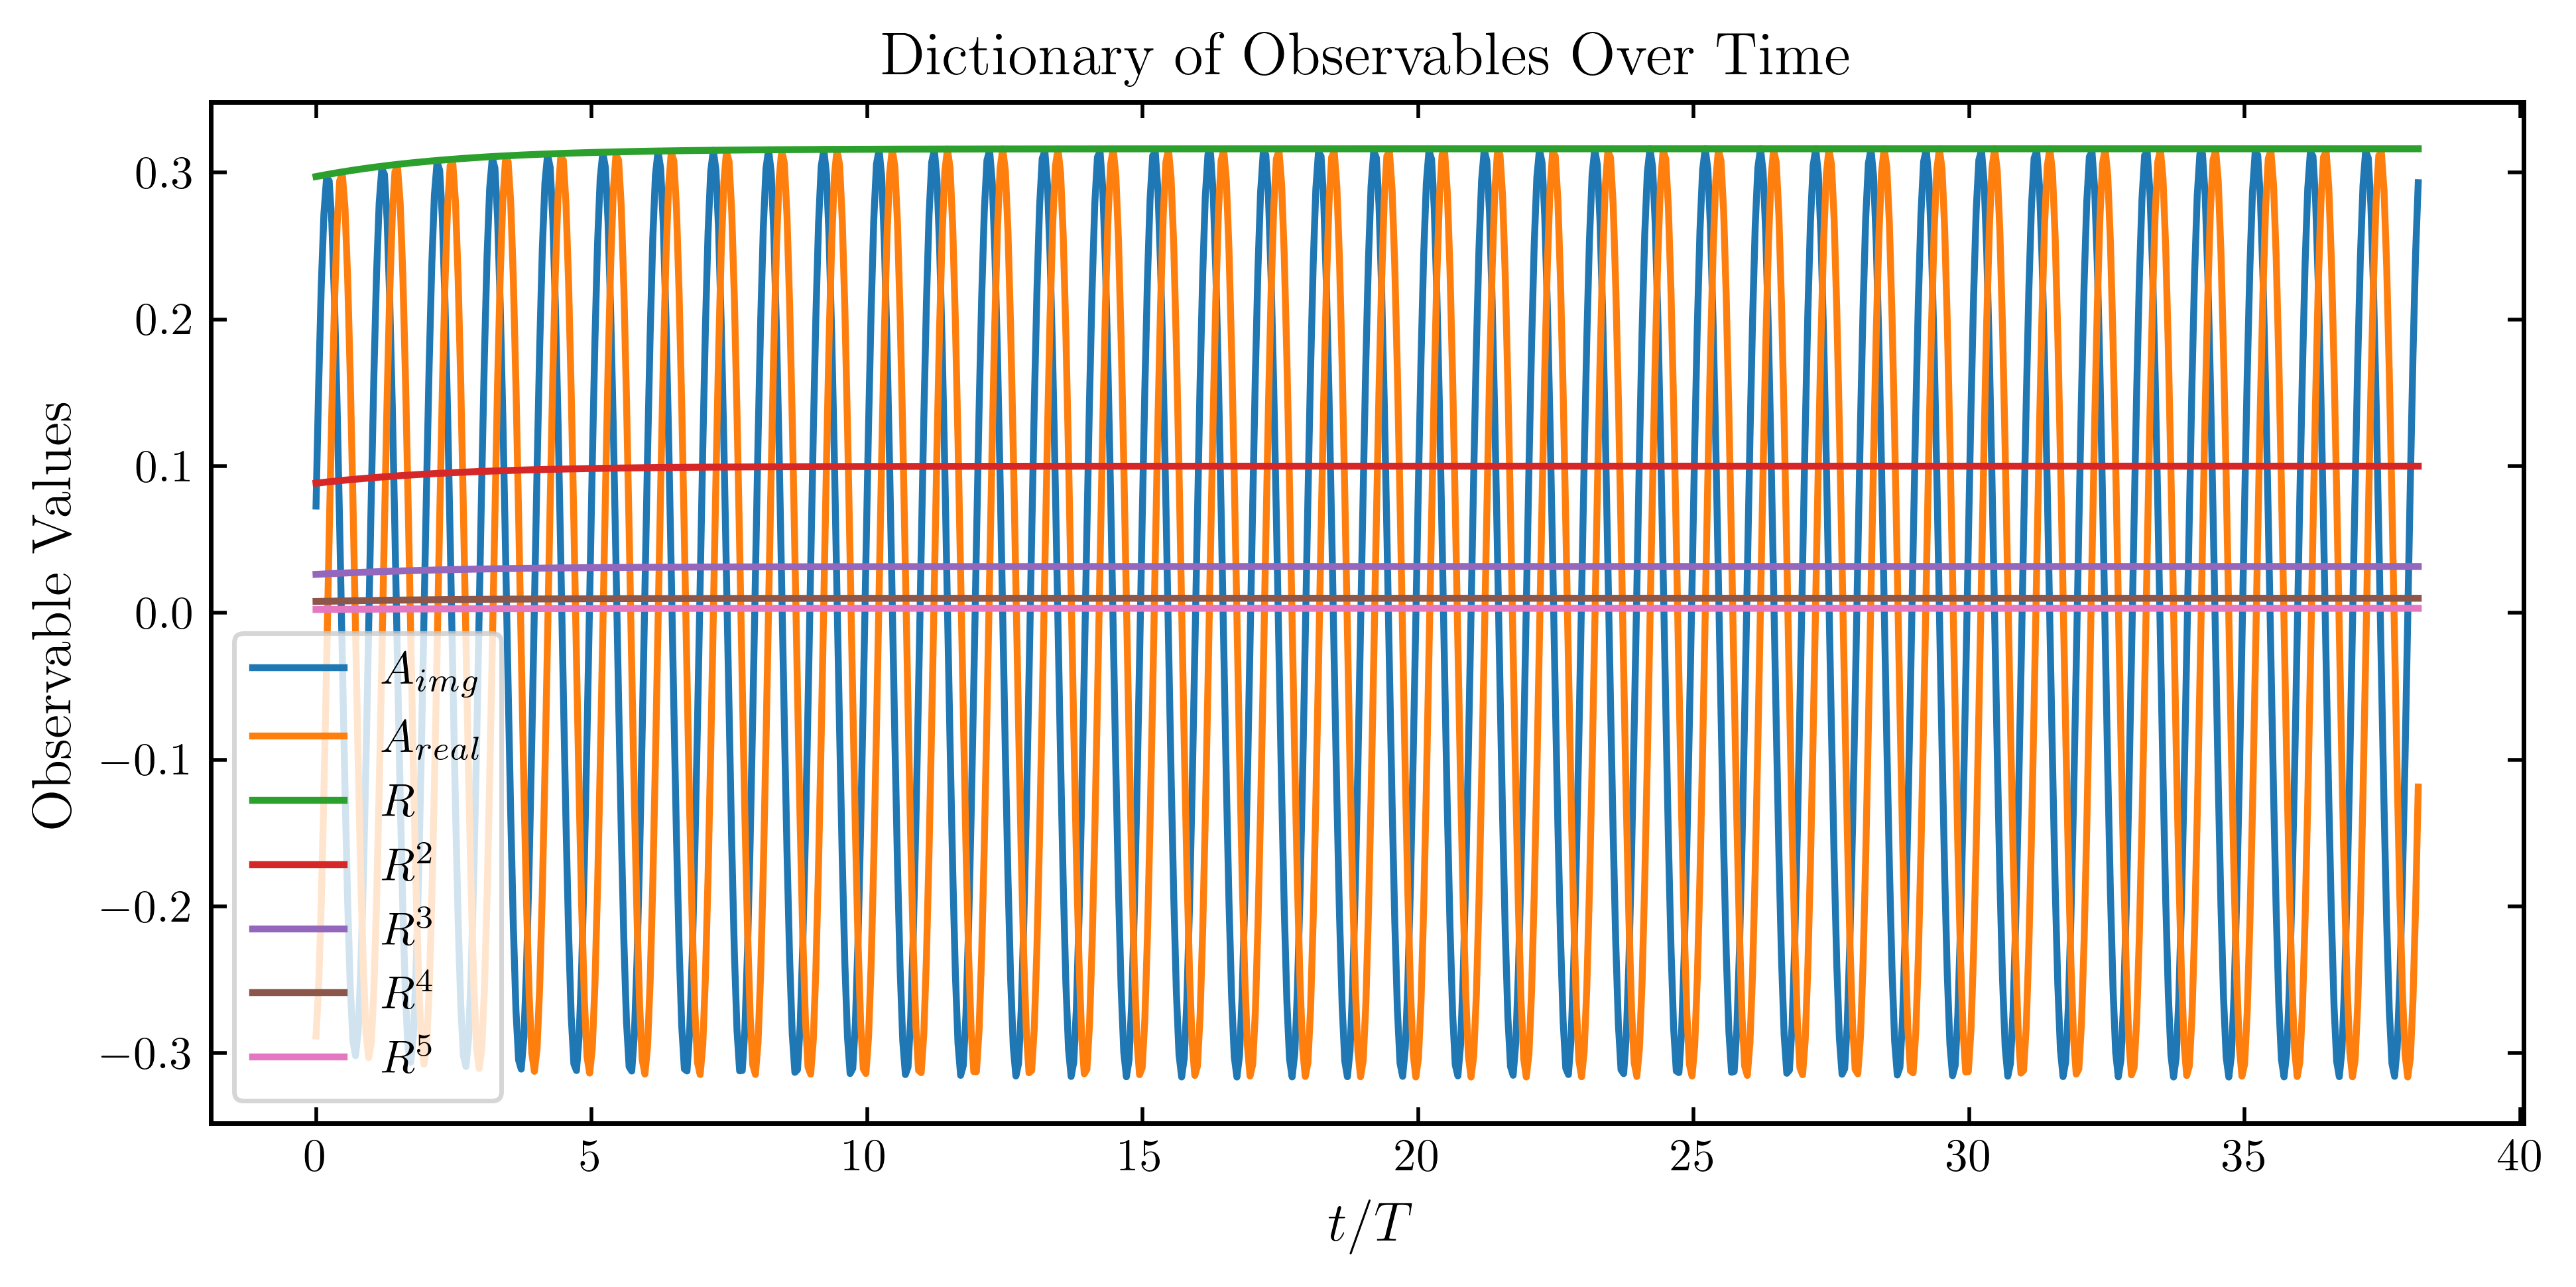

In [3]:
#Dictionary construction
obs_dict = np.vstack([states[:,0], states[:,1], states[:,2], states[:,2]**2, states[:,2]**3, states[:,2]**4
                     ,states[:,2]**5]).T
obss= [r"$A_{img}$", r"$A_{real}$", r"$R$", r"$R^2$", r"$R^3$", r"$R^4$", r"$R^5$"]
# obs_dict = np.vstack([states[:,0], states[:,1]]).T
obs_dict = obs_dict[1100:1900]
print(obs_dict.shape)

freq = omega/(2* np.pi)
T = 1/freq
t = np.arange(obs_dict.shape[0]) * dt/T

plt.figure(dpi=500)
for i in range(obs_dict.shape[1]):
    plt.plot(t, obs_dict[:,i], label=obss[i])

plt.ylabel('Observable Values')
plt.xlabel(r'$t/T$')
plt.title('Dictionary of Observables Over Time')
plt.legend(frameon=True)


We can now obtain the Koopman operator K as the minimizer of the following least squares optimization problem,

$$
\begin{equation}
    \mathbf{K} = \arg\min_{\mathbf{K}}\frac{1}{n_t}\left\|\mathbf{D}^{n_t+1} - \mathbf{K}\mathbf{D}^{n_t}\right\|_F^{2}.
\end{equation}
$$


In [4]:
from pydmd import DMD
data = obs_dict.T
dmd = DMD(svd_rank=-1)
dmd.fit(data)

/home/pg221/miniconda3/envs/koop_control/lib/python3.13/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 5451858117.084263. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


We now use this Koopman operator obtained through Extended DMD to predict the system's future states.

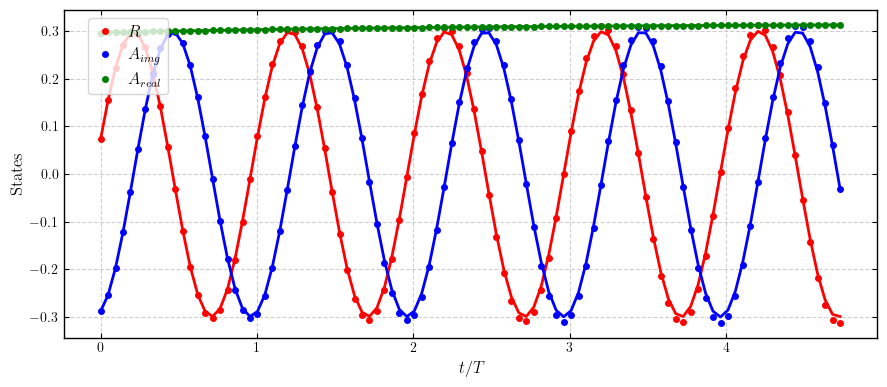

In [5]:

rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 11,          # main text font = 10 pt
    "axes.labelsize": 12,     # ≈ 1.1× main text
    "xtick.labelsize": 10,     # ≈ 0.9×
    "ytick.labelsize": 10,
    "legend.fontsize": 12,
    "mathtext.fontset": "cm",
    "axes.linewidth": 1.0,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
    "figure.figsize": (9, 4),
    "savefig.dpi": 500,
    "savefig.bbox": "tight",
})

plt.figure()
omega = 3.0
freq = omega/(2* np.pi)
T = 1/freq
t = np.arange(data.shape[1]) * dt/T

recon = dmd.reconstructed_data.real

n_plot = min(3, data.shape[0])
labels = [r"$R$",r"$A_{img}$", r"$A_{real}$"]
for i in range(n_plot):
    # plot original data as markers only, then reconstructed as solid line
    plt.plot(t[:100], data[i, :100].real, linestyle='None', marker='o', markersize=4, color=colors[i], label=f'{labels[i]}')
    plt.plot(t[:100], recon[i, :100].real, linewidth=2.0, color=colors[i],)


plt.xlabel(r'$t/T$')
plt.ylabel('States')
# plt.title('DMD Reconstruction vs Original')
plt.legend(frameon=True, loc='upper left', bbox_to_anchor=(0.02, 1.0), handlelength=1.2)

plt.grid(True, linestyle='--', alpha=0.6)
# plt.xlim(t[0], t[-1])
plt.tight_layout()

In the plot above, the dotted line represents the predicted trajectory, while solid lines represent the true trajectory.


# Eigendecomposition of the Koopman Operator

The eigendecomposition of the Koopman operator $\mathbf{K}$ allows us to express its action in terms of modes and eigenvalues:

$$
\mathbf{K} = \mathbf{V}\mathbf{\Lambda}\mathbf{V}^{-1}
$$

where $\mathbf{V}$ contains the eigenvectors (modes) and $\mathbf{\Lambda}$ is a diagonal matrix of eigenvalues. This decomposition reveals the underlying linear structure in the lifted observables space.

To extract continuous-time eigenvalues from the discrete DMD eigenvalues, we use the relationship:

$$
\lambda_{\text{continuous}} = \frac{\log(\lambda_{\text{discrete}})}{\Delta t}
$$

The extracted eigenvalues from the extended DMD are then compared with the analytical eigenvalues derived from the Stuart-Landau equation. This comparison validates the accuracy of the EDMD in capturing the system's spectral properties.

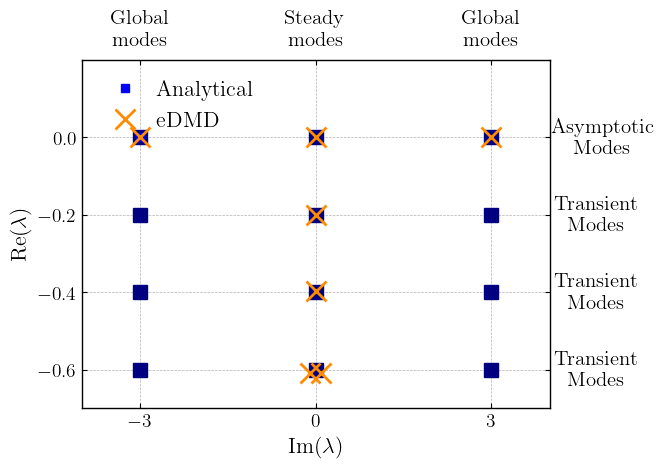

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams.update({
    "font.family": "serif",
    "font.size": 16,
    "axes.labelsize": 16,
    "axes.titlesize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 16,
    "mathtext.fontset": "cm",
    "axes.linewidth": 1.0,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
    "figure.figsize": (7, 5),
    "savefig.dpi": 500,
    "savefig.bbox": "tight",
})

# ====== Parameters ======
w0 = 3.0
dt = 0.1

# Analytical eigenvalues
j = np.arange(5)
m = np.array([-1, 0, 1])
M, J = np.meshgrid(m, j)
analytical_eigs = -0.2 * J + 1j * M * w0

# ====== DMD continuous eigenvalues (example placeholder) ======
cont_eigs = np.log(dmd.eigs) / (dt)

# ====== Plot ======
fig, ax = plt.subplots()

# Analytical modes
ax.plot(np.imag(analytical_eigs), np.real(analytical_eigs),
        's', color='navy', markersize=10)

ax.plot(np.imag(analytical_eigs[0,0]), np.real(analytical_eigs[0,0]), "s", color = "blue", label='Analytical')

# DMD modes
ax.plot(cont_eigs.imag, cont_eigs.real,
        'x', color='darkorange', markersize=14, mew=2.0, label='eDMD')


# Axes and grid
ax.set_xlim(-4, 4)
ax.set_ylim(-0.7, 0.2)
ax.set_xlabel(r'$\mathrm{Im}(\lambda)$')
ax.set_ylabel(r'$\mathrm{Re}(\lambda)$')
ax.set_xticks([-3, 0, 3])
ax.set_yticks([-0.6,-0.4,-0.2,0.0])
ax.grid(True, linestyle='--', linewidth=0.5)

# Text annotations
ax.text(-3, 0.28, 'Global\nmodes', ha='center', va='center', fontsize=15)
ax.text(-0, 0.28, 'Steady\nmodes', ha='center', va='center', fontsize=15)
ax.text(3, 0.28, 'Global\nmodes', ha='center', va='center', fontsize=15)

plt.gca().text(4.9, -0.0, 'Asymptotic\n Modes', ha='center', va='center', fontsize=15)
plt.gca().text(4.8, -0.2, 'Transient\n Modes', ha='center', va='center', fontsize=15)
plt.gca().text(4.8, -0.4, 'Transient\n Modes', ha='center', va='center', fontsize=15)
plt.gca().text(4.8, -0.6, 'Transient\n Modes', ha='center', va='center', fontsize=15)

# Legend
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(0.02, 1.0), handlelength=1.2)

# Tight layout for publication
plt.tight_layout()
# plt.show()

# plt.savefig('figs/SL_eDMD_eigenvalues.png', dpi=500, bbox_inches='tight', transparent=True)